<a href="https://colab.research.google.com/github/Ragavan7071/ece-cit/blob/master/final_of_poetry_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [116]:
import tensorflow as tf
import numpy as np
import os
import time
import cv2
import matplotlib.pyplot as plt
from google.colab import files


In [ ]:
!git clone https://github.com/Ragavan7071/ece-cit.git

In [ ]:
#weights for object detection
!wget https://pjreddie.com/media/files/yolov3.weights

In [162]:
#for image dataset in input
net = cv2.dnn.readNet("/content/yolov3.weights", "/content/ece-cit/detect.cfg")
classes = []
with open("/content/coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
colors = np.random.uniform(0, 255, size=(len(classes), 3))


In [150]:
#for text dataset in poem
test='/content/ece-cit/test.txt'
text1 = open(test,'rb').read().decode(encoding='cp1251')
text=text1.replace("<eos>","\n")
print ('Length of text: {} characters'.format(len(text)))

Length of text: 1938966 characters


In [151]:
vocab = sorted(set(text))
print ('{} unique characters'.format(len(vocab)))

89 unique characters


In [186]:
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)
text_as_int = np.array([char2idx[c] for c in text])

In [187]:
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n':   0,
  '\r':   1,
  ' ' :   2,
  '!' :   3,
  '"' :   4,
  '$' :   5,
  '%' :   6,
  "'" :   7,
  '(' :   8,
  ')' :   9,
  '*' :  10,
  ',' :  11,
  '.' :  12,
  '0' :  13,
  '1' :  14,
  '2' :  15,
  '3' :  16,
  '4' :  17,
  '5' :  18,
  '6' :  19,
  ...
}


In [188]:
# The maximum length sentence we want for a single input in characters
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)
# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
for i in char_dataset.take(5):
  print(idx2char[i.numpy()])

w
i
t
h
 


In [189]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)
for item in sequences.take(5):
  print(repr(''.join(idx2char[item.numpy()])))

'with clytia he no longer was received \n than while he was a man of wealth believed \n balls , concerts'
" , op'ras , tournaments , and plays \n expensive dresses , all engaging ways \n were used to captivate "
'this lady fair \n while scarcely one around but in despair \n wife , widow , maid , his fond affection '
"sought \n to gain him , ev'ry wily art was brought \n but all in vain :— by passion overpow'red \n the b"
'elle , whose conduct others would have soured \n to him appeared a goddess full of charms \n superior e'


In [190]:
def split_input_target(chunk):
  input_text = chunk[:-1]
  target_text = chunk[1:]
  return input_text, target_text
dataset = sequences.map(split_input_target)

In [191]:
for input_example, target_example in  dataset.take(1):
  print ('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
  print ('Target data:', repr(''.join(idx2char[target_example.numpy()])))

Input data:  'with clytia he no longer was received \n than while he was a man of wealth believed \n balls , concert'
Target data: 'ith clytia he no longer was received \n than while he was a man of wealth believed \n balls , concerts'


In [192]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
  print("Step {:4d}".format(i))
  print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
  print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step    0
  input: 54 ('w')
  expected output: 40 ('i')
Step    1
  input: 40 ('i')
  expected output: 51 ('t')
Step    2
  input: 51 ('t')
  expected output: 39 ('h')
Step    3
  input: 39 ('h')
  expected output: 2 (' ')
Step    4
  input: 2 (' ')
  expected output: 34 ('c')


In [193]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

In [194]:
# Length of the vocabulary in chars
vocab_size = len(vocab)
# The embedding dimension
embedding_dim = 256
# Number of RNN units
rnn_units = 1024

In [195]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.GRU(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

In [196]:
model = build_model(vocab_size = len(vocab),embedding_dim=embedding_dim,rnn_units=rnn_units,batch_size=BATCH_SIZE)

In [197]:
for input_example_batch, target_example_batch in dataset.take(1):
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape)

(64, 100, 89)


In [198]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (64, None, 256)           22784     
_________________________________________________________________
gru_9 (GRU)                  (64, None, 1024)          3938304   
_________________________________________________________________
dense_9 (Dense)              (64, None, 89)            91225     
Total params: 4,052,313
Trainable params: 4,052,313
Non-trainable params: 0
_________________________________________________________________


In [199]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

In [200]:
sampled_indices

array([ 0, 53, 25, 14, 27, 31, 87, 42, 55, 51,  0, 87, 29, 61, 72, 33, 31,
       15, 79, 30, 80, 66, 78, 47, 41, 60,  1, 57, 78, 18, 24, 52, 75, 21,
       46, 57,  4,  3,  9,  1, 76, 29, 43, 77, 84, 36,  3,  4, 41, 21, 60,
       88, 25, 53, 17, 78, 75, 60, 78, 15, 18, 69, 49, 83, 36,  9, 85, 56,
       13,  3, 86,  4, 63, 21, 19, 14, 30, 50, 21, 38, 11, 35, 59, 22, 75,
        0, 57,  5, 66, 16, 80, 38, 57, 86, 55, 76,  8, 86, 70, 72])

In [201]:
print("Input:", repr("".join(idx2char[input_example_batch[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices ])))

Input: 'gleams \n of ruined turrets , barren in the light \n to watch the changing clouds , like clime in clim'

Next Char Predictions: 
 '\nv<1?`“kxt\n“[»нb`2ц]щдфpj«\rzф5;uс8oz"!)\rт[lу—e!"j8«”<v4фс«ф25йrњe)‘y0!’"а861]s8g,d}9с\nz$д3щgz’xт(’кн'


In [202]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss  = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape)
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 100, 89)
scalar_loss:       4.4881625


In [203]:
model.compile(optimizer='adam', loss=loss)

In [204]:
checkpoint_dir = '/content/ece-cit/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,save_weights_only=True)

In [205]:
history = model.fit(dataset, epochs=10, callbacks=[checkpoint_callback])

Epoch 1/10
299/299 [==============================] - 22s 72ms/step - loss: 2.2569
Epoch 2/10
299/299 [==============================] - 22s 73ms/step - loss: 1.6893
Epoch 3/10
299/299 [==============================] - 22s 73ms/step - loss: 1.5200
Epoch 4/10
299/299 [==============================] - 22s 74ms/step - loss: 1.4338
Epoch 5/10
299/299 [==============================] - 22s 75ms/step - loss: 1.3806
Epoch 6/10
299/299 [==============================] - 23s 75ms/step - loss: 1.3402
Epoch 7/10
299/299 [==============================] - 22s 75ms/step - loss: 1.3072
Epoch 8/10
299/299 [==============================] - 22s 75ms/step - loss: 1.2762
Epoch 9/10
299/299 [==============================] - 22s 75ms/step - loss: 1.2476
Epoch 10/10
299/299 [==============================] - 22s 75ms/step - loss: 1.2192


In [206]:
tf.train.latest_checkpoint(checkpoint_dir)

'/content/ece-cit/training_checkpoints/ckpt_10'

In [207]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [208]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (1, None, 256)            22784     
_________________________________________________________________
gru_10 (GRU)                 (1, None, 1024)           3938304   
_________________________________________________________________
dense_10 (Dense)             (1, None, 89)             91225     
Total params: 4,052,313
Trainable params: 4,052,313
Non-trainable params: 0
_________________________________________________________________


In [209]:
with open("/content/st.names",'r') as w:
    c = [line.strip() for line in w.readlines()]

In [210]:
#image detections
def detections(image):
 img = cv2.imread(image)
 img = cv2.resize(img, None, fx=0.6, fy=0.6)
 height, width, channels = img.shape
 blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
 net.setInput(blob)
 outs = net.forward(output_layers)
 class_ids = []
 confidences = []
 boxes = []
 for out in outs:
     for detection in out:
         scores = detection[5:]
         class_id = np.argmax(scores)
         confidence = scores[class_id]
         if confidence > 0.5:
             # Object detected
             center_x = int(detection[0] * width)
             center_y = int(detection[1] * height)
             w = int(detection[2] * width)
             h = int(detection[3] * height)

            # Rectangle coordinates
             x = int(center_x - w / 2)
             y = int(center_y - h / 2)

             boxes.append([x, y, w, h])
             confidences.append(float(confidence))
             class_ids.append(class_id)

 indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
 
 font = cv2.FONT_HERSHEY_PLAIN
 for i in range(len(boxes)):
     if i in indexes:
         x, y, w, h = boxes[i]
         label = str(classes[class_ids[i]])
         labell=str(c[class_ids[i]])
         color = colors[class_ids[i]]
         cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
         cv2.putText(img, label, (x, y + 30), font, 3, color, 3)
         
 plt.imshow(img)        
 cv2.destroyAllWindows()
 return (label,labell) 

In [211]:
#poem model
def generate_text(model, start_string):
  # Evaluation step (generating text using the learned model)

  # Number of characters to generate
  num_generate = 630
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  text_generated = []

  temperature = 1.2

  model.reset_states()
  for i in range(num_generate):
    # using a categorical distribution to predict the character returned by the model
    predictions = model(input_eval)
    predictions = tf.squeeze(predictions, 0)

    predictions = predictions / temperature
    predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

    input_eval = tf.expand_dims([predicted_id], 0)

    text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))

In [214]:
def upload():
 uploaded = files.upload() 
 for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
 return (name)

please give an clarity and common images image as input,
you can choose from input gallery
your photo:


Saving download (2).jpg to download (2).jpg

The context from the image is: toothbrush
The starting line relavent to the given image: brush! brush! two a times a day.

 The poem is:

brush! brush! two a times a day. or did harme against towl 
 away on “ ensse in my summer blossoming castfull , and penitent you madgen 
 a myrtles , rose from me to me desirt 
 what velymations born demands 
 somewill i do , mertyl radiance 's dread 
 to whom i give folly keeps that unget hark 
 suspenser — o my e delice fit for mine he guide ; to you supre 
 no sor two rude , hirtless , hut feidors 
 of matter used let me seest a mincle 
 flut to extet unpised 
 thou seest , cursund mourn 'd for iove now heart 
 discredit . he can scorch allow me power 
 bore hide in husband 's eyring night yet never fain 
 judgmentsber , and , how tending out of riot 


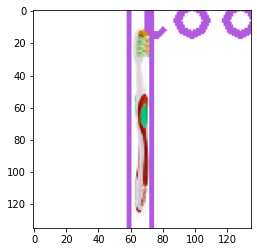

In [215]:
print("please give an clarity and common images image as input,\nyou can choose from input gallery")
print('your photo:')
input_image=upload()
context,starts=detections(input_image)
starts=starts.lower()
print('\nThe context from the image is:',context)
print("The starting line relavent to the given image:",starts)
print("\n The poem is:\n")
print(generate_text(model, start_string=starts))

In [173]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
